## Import Packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #随机森林模型
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

## Read File

In [2]:
data = pd.read_csv("CW_project4.txt", sep=" ", header=None)
data = data.drop(columns=6, axis=1)
data = data.rename(columns={7:6})


## Data Exploration 

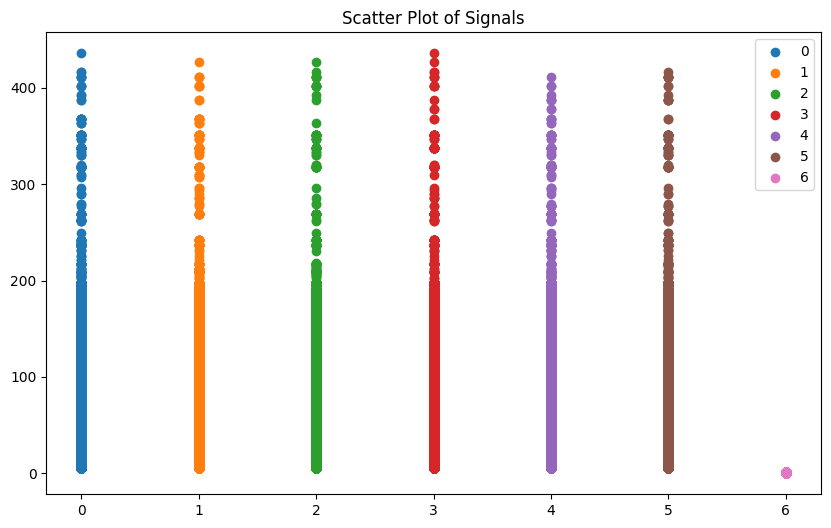

In [3]:
plt.figure(figsize=(10, 6))
for col in data.columns:
    plt.scatter([col] * len(data), data[col], label=col)

plt.legend()
plt.title("Scatter Plot of Signals")
plt.show()



## Use isolation forest to remove outliers

In [4]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
original_length = len(X)

IF = IsolationForest(contamination=0.05)
outliers = IF.fit_predict(X)

X = X[outliers != -1]
y = y[outliers != -1]

new_length = len(X)

removed_data_count = original_length - new_length

print(f"{removed_data_count} data has been removed")



50000 data has been removed


## Use a DNN model plus k-fold validation(k = 10) to train model

In [ ]:
# 创建k-fold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy = []  # 用于存储每次验证的准确率
all_y_val = []  # 存储所有验证的真实标签
all_y_pred_val = []  # 存储所有验证的预测值

# 使用k-fold进行十次循环
for train_index, val_index in kf.split(X, y):
    # 为当前循环划分训练集和验证集
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # 创建一个Sequential模型，使用多个Dense层
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(6,)), # 第一层，256个神经元，ReLU激活函数，输入层
        layers.Dense(128, activation='relu'), # 第二层，128个神经元，ReLU激活函数
        layers.Dense(64, activation='relu'),  # 第三层，64个神经元，ReLU激活函数
        layers.Dense(1, activation='sigmoid') # 输出层，1个神经元，sigmoid激活函数用于二分类
    ])
    
    # 编译模型，使用Adam优化器，二元交叉熵作为损失函数，准确率作为评估指标
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 训练模型，使用X_train和y_train，进行10个周期，批量大小为32，同时使用验证数据X_val和y_val
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # 绘制损失和准确率曲线
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # 使用模型进行预测
    y_pred_val = model.predict(X_val)
    all_y_val.extend(y_val)
    all_y_pred_val.extend(y_pred_val)
    accuracy.append(history.history['val_accuracy'][-1])

# 计算平均验证准确率
print(f"Mean validation accuracy: {sum(accuracy)/len(accuracy):.4f}")

# 使用所有的验证数据进行评估并绘制ROC、PR曲线和混淆矩阵
all_y_val = np.array(all_y_val)
all_y_pred_val = np.array(all_y_pred_val).ravel()

# ROC曲线
fpr, tpr, thresholds = roc_curve(all_y_val, all_y_pred_val)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(all_y_val, all_y_pred_val)
plt.figure()
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 混淆矩阵
matrix = confusion_matrix(all_y_val, np.round(all_y_pred_val))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 分类报告
y_pred_class = np.round(all_y_pred_val)
report = classification_report(all_y_val, y_pred_class, target_names=["background", "signal"])
print(report)

In [ ]:

from sklearn.preprocessing import MinMaxScaler
# 读取文件
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

# 随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=0, verbose=2, n_jobs=4)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, preds)
print("准确率：", accuracy)

# 打印分类报告，包括精确度、召回率、F1分数等
report = classification_report(y_test, preds)
print("分类报告：\n", report)

# 计算 Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)

# 计算 ROC
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# 画 PR 曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# 画 ROC 曲线
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

#计算混淆矩阵
conf_matrix = confusion_matrix(y_test, preds)

# 画混淆矩阵
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ["Background", "Signal"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()